In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os

In [20]:
def plot_band(ax, x, y, band_scale=0, label=None, color=None):
    """Plot mean and min-to-max color band for stacked data y.

    Parameters
    ----------
    ax : plt.axes.Axes
        Target plot.
    x : np.array
        x data array, with shape (time).
    y : np.array
        y data array, with shape (trajectory idx, time).

    Keyword Args
    ------------
    band_scale : float
        Lower and upper band variance multiplier. If 0, uses min/max instead.
    label : str
        Line label for legend.
    color : str
        Line/shading color.
    """

    mean = np.mean(y, axis=0)

    if band_scale == 0:
        lower = np.min(y, axis=0)
        upper = np.max(y, axis=0)
    else:
        stddev = np.sqrt(np.var(y, axis=0))
        mean = np.mean(y, axis=0)
        lower = mean - band_scale * stddev
        upper = mean + band_scale * stddev

    mean_line, = ax.plot(x, mean, label=label, color=color)
    ax.fill_between(x, lower, upper, alpha=0.25, color=mean_line.get_color())
    return mean_line


In [38]:
def val_best(d):
    indices = np.argmin(d['val'], axis=1)
    return d['test'][np.arange(indices.shape[0]), indices]

In [90]:
ds = dict(np.load("../data/polybench/20-40.npz"))

experiments = [
    "rank1", "rank8", "rank32", "nn8", "nn32", "opcodes8", "opcodes32",
    "pca8", "pca32", "both8", "both32", "linearopcodes"
]
sparsity = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

data = {
    k: [np.load(
        os.path.join("results", k, "{}.npz".format(s))) for s in sparsity]
    for k in experiments
}
val_last = {
    k: np.array([p['val'][:, -1] for p in v]) for k, v in data.items()
}
train_last = {
    k: np.array([p['train'][:, -1] for p in v]) for k, v in data.items()
}
test_loss = {
    k: np.array([val_best(p) for p in v]) for k, v in data.items()
}

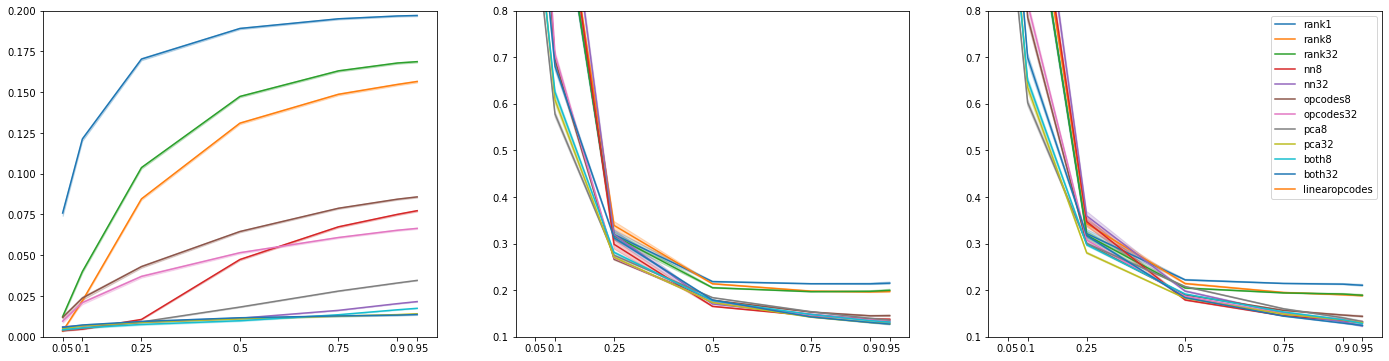

In [78]:
def ablate(ax, data):
    for experiment, val in data.items():
        plot_band(
            ax, sparsity, np.sqrt(val).T,
            band_scale=2 / np.sqrt(1000), label=experiment)
        ax.set_xticks(sparsity)
        ax.set_xticklabels(sparsity)
        ax.set_xlim(0, 1)

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

ablate(axs[0], train_last)
ablate(axs[1], test_loss)
ablate(axs[2], val_last)
axs[0].set_ylim(0, 0.2)
axs[1].set_ylim(0.1, 0.8)
axs[2].set_ylim(0.1, 0.8)
axs[-1].legend()

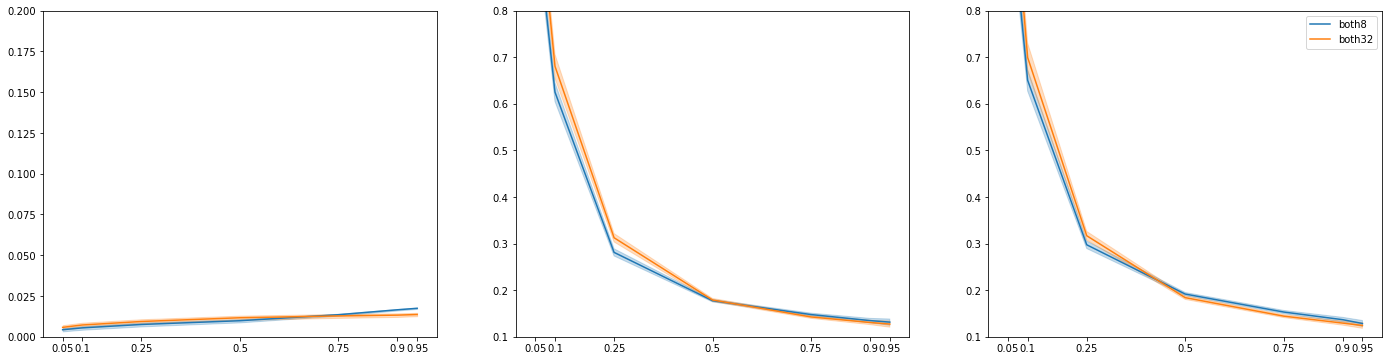

In [92]:
exps = ["both8", "both32"]

def ablate(ax, data):
    for experiment in exps:
        plot_band(ax, sparsity, np.sqrt(data[experiment]).T, band_scale=0.2, label=experiment)
        ax.set_xticks(sparsity)
        ax.set_xticklabels(sparsity)
        ax.set_xlim(0, 1)

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

ablate(axs[0], train_last)
ablate(axs[1], test_loss)
ablate(axs[2], val_last)
axs[0].set_ylim(0, 0.2)
axs[1].set_ylim(0.1, 0.8)
axs[2].set_ylim(0.1, 0.8)
axs[-1].legend()

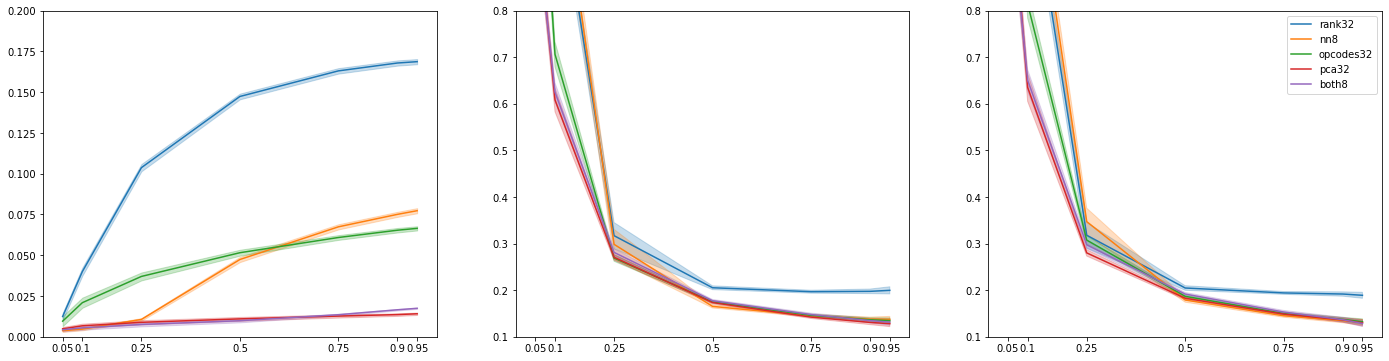

In [89]:
exps = ["rank32", "nn8", "opcodes32", "pca32", "both8"]

def ablate(ax, data):
    for experiment in exps:
        plot_band(ax, sparsity, np.sqrt(data[experiment]).T, band_scale=0.2, label=experiment)
        ax.set_xticks(sparsity)
        ax.set_xticklabels(sparsity)
        ax.set_xlim(0, 1)

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

ablate(axs[0], train_last)
ablate(axs[1], test_loss)
ablate(axs[2], val_last)
axs[0].set_ylim(0, 0.2)
axs[1].set_ylim(0.1, 0.8)
axs[2].set_ylim(0.1, 0.8)
axs[-1].legend()

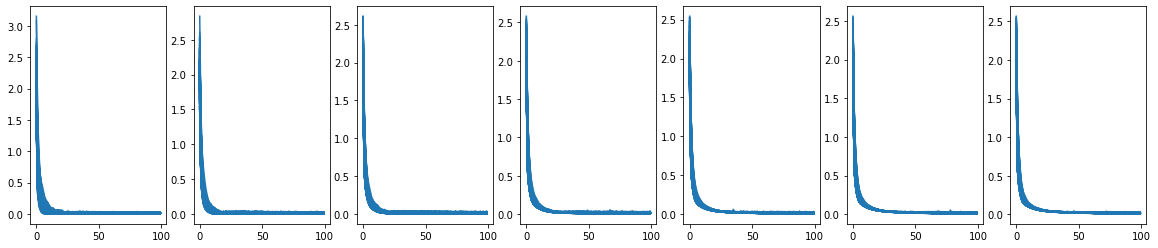

In [74]:
fig, axs = plt.subplots(1, 7, figsize=(20, 4))

for dp, ax in zip(data["pca32"], axs):
    ax.plot(np.sqrt(dp["train"].T), color='C0')
    # ax.plot(np.sqrt(dp["val"].T), color='C1')
    # ax.plot(np.sqrt(dp["test"].T), color='C2')

In [37]:
train = np.where(1 - data['mf_both_32'][5]['split_train'])
errors = np.array((data["mf_both_32"][5]['pred'] - ds.matrix)[train[0], train[1], train[2]])

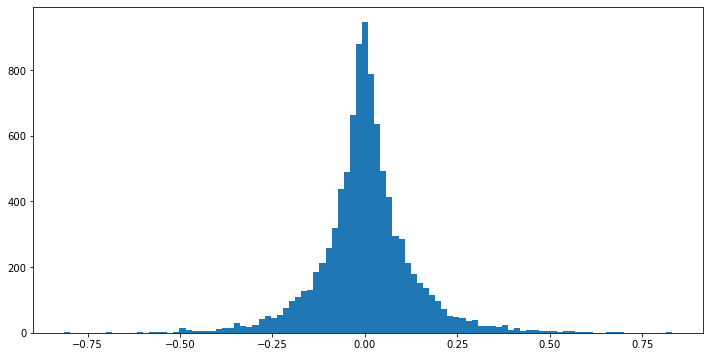

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
_ = axs.hist(errors, bins=100)

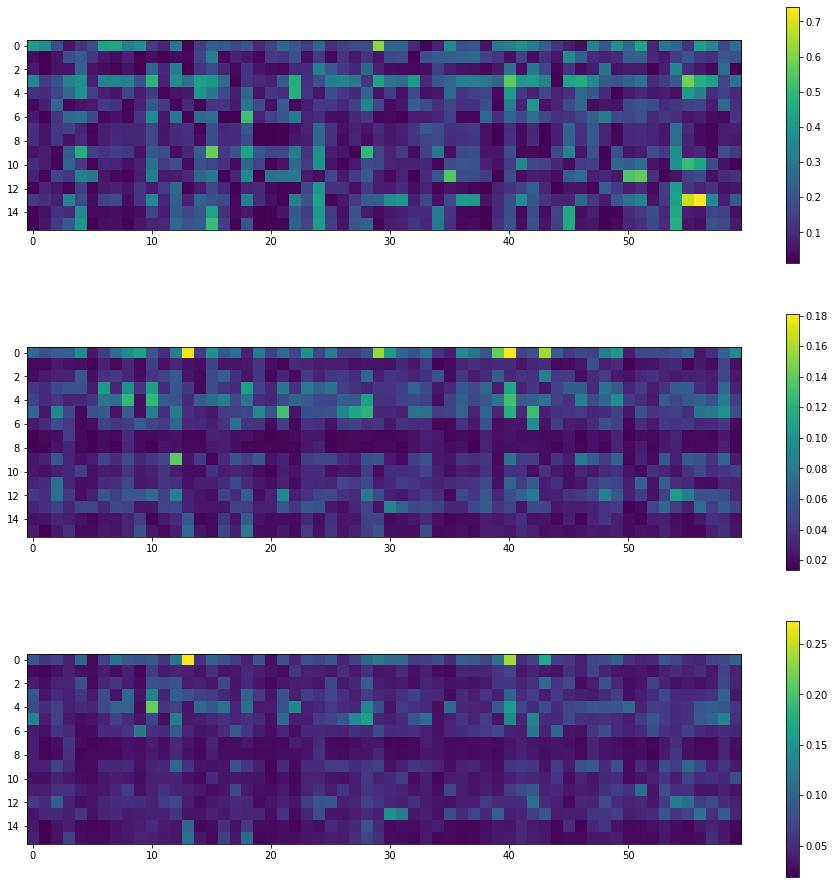

In [6]:
def mse(pred):
    return np.sqrt(np.mean(np.square(pred - ds["runtime"]), axis=0)).T

fig, axs = plt.subplots(3, 1, figsize=(16, 16))


for exp, ax in zip(['mf_linear', 'mf_pca_32', 'mf_both_8'], axs):
    pos = ax.imshow(mse(data[exp][5]['pred']))
    fig.colorbar(pos, ax=ax)
